In [1]:
from pystac_client import Client
import planetary_computer
import rasterio
import matplotlib.pyplot as plt

# Connect to Planetary Computer
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                      modifier=planetary_computer.sign_inplace)

In [3]:
# Define region (example: forested area in California)
bbox = [-120.2, 37.0, -119.8, 37.4]  # minlon, minlat, maxlon, maxlat
search = catalog.search(
    collections=["naip"],
    bbox=bbox,
    datetime="2018-01-01/2020-12-31"
)

items = list(search.item_collection())


In [10]:
item_before = items[0]  # older image
item_after = items[-1]  # recent image

def download_image(item, out_path):
    href = planetary_computer.sign(item.assets["image"].href)
    with rasterio.open(href) as src:
        data = src.read()  # RGB
        meta = src.meta
        # meta.update(count= 3)
    with rasterio.open(out_path, "w", **meta) as dest:
        dest.write(data)

download_image(item_before, "../data/naip_before.tif")
download_image(item_after, "../data/naip_after.tif")


In [9]:
href = planetary_computer.sign(item_before.assets["image"].href)
with rasterio.open(href) as src:
    print(f"Number of bands: {src.count}")
    print(f"Band descriptions: {src.descriptions}")
    print(f"Data type: {src.dtypes}")

Number of bands: 4
Band descriptions: (None, None, None, None)
Data type: ('uint8', 'uint8', 'uint8', 'uint8')


In [12]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Load the image
with rasterio.open("../data/naip_before.tif") as src:
    img = src.read()  # shape: (bands, height, width)
    meta = src.meta

print(img.shape)

(4, 12500, 10290)


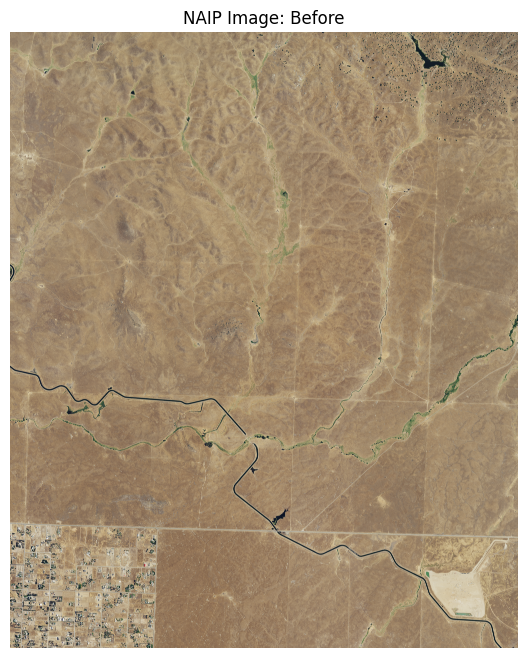

In [13]:
# Normalize and transpose for matplotlib
rgb = np.transpose(img[:3], (1, 2, 0))  # (H, W, C)
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalize to 0-1

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("NAIP Image: Before")
plt.axis('off')
plt.show()

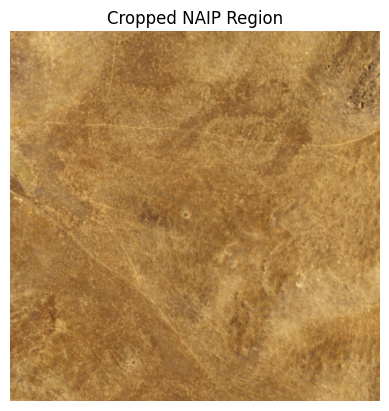

In [1]:
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np

# Load image and crop a region
with rasterio.open("../data/naip_before.tif") as src:
    crop_window = Window(1000, 1000, 512, 512)  # (col_off, row_off, width, height)
    cropped = src.read(window=crop_window)     # shape: (bands, 512, 512)
    meta = src.meta

# Visualize
img_rgb = np.transpose(cropped[:3], (1, 2, 0))  # RGB only
img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())  # Normalize 0-1

plt.imshow(img_rgb)
plt.title("Cropped NAIP Region")
plt.axis('off')
plt.show()


In [2]:
import torch
from torchvision import transforms

# Define preprocessing
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply transforms
input_tensor = preprocess(img_rgb).unsqueeze(0)  # (1, 3, 512, 512)


In [6]:
import torch
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101

# Define preprocessing
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply transforms and ensure float32
input_tensor = preprocess(img_rgb).unsqueeze(0).float()  # Add .float()

# Load pretrained model
model = deeplabv3_resnet101(pretrained=True).eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
input_tensor = input_tensor.to(device)

# Inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]  # (21, H, W)

# Get predicted class map
predicted_classes = output.argmax(0).cpu().numpy()  # (H, W)

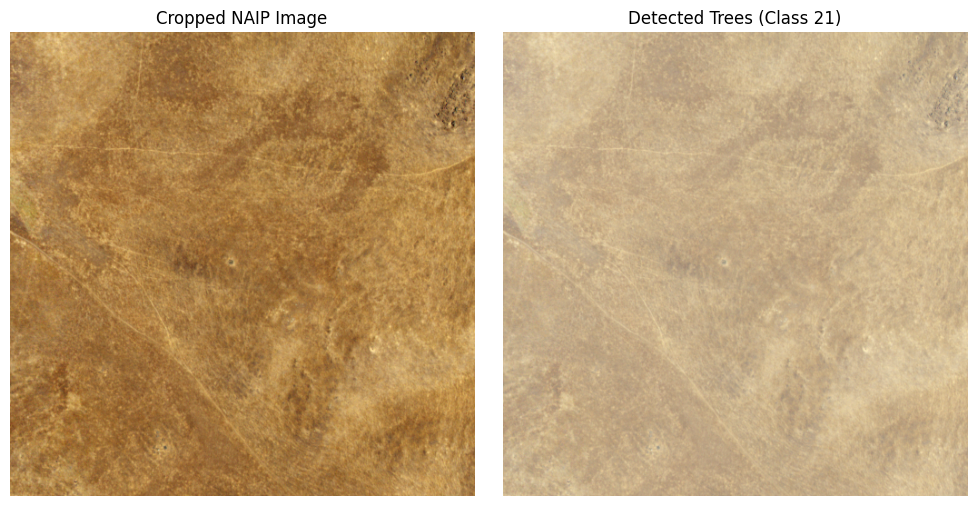

In [7]:
# Highlight class 21 (trees)
mask = (predicted_classes == 21)

# Overlay mask on image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Cropped NAIP Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_rgb)
plt.imshow(mask, cmap="Greens", alpha=0.4)
plt.title("Detected Trees (Class 21)")
plt.axis("off")

plt.tight_layout()
plt.show()
